In [1]:
from typing import List, Optional
import urllib.request
from tqdm import tqdm
from pathlib import Path
import requests
import torch
import math
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader



torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


# Setup and Exploration

In [3]:
def download_quickdraw_dataset(root="../data/npy", class_names: List[str]=None):
    root = Path(root)
    root.mkdir(exist_ok=True, parents=True)
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

    print("Downloading Quickdraw Dataset...")
    for class_name in tqdm(class_names, leave=True):
        fpath = root / f"{class_name}.npy"
        if not fpath.exists():
            urllib.request.urlretrieve(f"{url}{urllib.parse.quote(class_name, safe='')}.npy", fpath)


def load_quickdraw_data(root="../data/npy", max_items_per_class=5000):
    all_files = Path(root).glob('*.npy')

    x = np.empty([0, 784], dtype=np.uint8)
    y = np.empty([0], dtype=np.long)
    class_names = []

    print(f"Loading {max_items_per_class} examples for each class from the Quickdraw Dataset...")
    for idx, file in enumerate(tqdm(sorted(all_files))):
        data = np.load(file, mmap_mode='r')
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)
        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_names.append(file.stem)

    return x, y, class_names


class QuickDrawDataset(torch.utils.data.Dataset):
    def __init__(self, root, max_items_per_class=5000, class_limit=None):
        super().__init__()
        self.root = root
        self.max_items_per_class = max_items_per_class
        self.class_limit = class_limit

        self.X, self.Y, self.classes = load_quickdraw_data(self.root, self.max_items_per_class)

    def __getitem__(self, idx):
        x = (self.X[idx] / 255.).astype(np.float32).reshape(1, 28, 28)
        y = self.Y[idx]

        return torch.from_numpy(x), y.item()

    def __len__(self):
        return len(self.X)

    def collate_fn(self, batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.LongTensor([item[1] for item in batch])
        return {'pixel_values': x, 'labels': y}
    
    def split(self, pct=0.1):
        num_classes = len(self.classes)
        indices = torch.randperm(len(self)).tolist()
        n_val = math.floor(len(indices) * pct)
        train_ds = torch.utils.data.Subset(self, indices[:-n_val])
        val_ds = torch.utils.data.Subset(self, indices[-n_val:])
        return train_ds, val_ds
    
    def draw_image(self, idx):
        plt.figure()
        plt.imshow(self[0][0].reshape(28,28,1), cmap='Greys')
        plt.title(self.classes[self[0][1]])
        plt.show()
        
    def draw_mean_image(self, label):
        images = []
        for idx, drawing in enumerate(self):
            if drawing[1] == label:
                images.append(drawing[0].numpy())

        mean_img = np.mean(np.array(images), axis=0)
        plt.figure()
        plt.imshow(mean_img.reshape(28,28,1), cmap='Greys')
        plt.title(self.classes[label])
        plt.show()

In [4]:
download_quickdraw_dataset(class_names = 
    ['airplane', 'apple', 'wine bottle', 'car', 'mouth', 'pineapple', 'umbrella', 'pear', 'moustache', 'smiley face']
    + ['train', 'mosquito', 'bee', 'dragon', 'piano']
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.53s/it]


In [5]:
dataset = QuickDrawDataset(root = '../data/npy')

/var/folders/fj/ycvwjvdn2cn32t7zm3h8jlq80000gn/T/ipykernel_48369/4157295013.py:17: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.empty([0], dtype=np.long)


Loading 5000 examples for each class from the Quickdraw Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.61it/s]


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2)



    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
for c in dataset.classes:
    print(f"{c} : {dataset.classes.index(c)}")


airplane : 0
apple : 1
bee : 2
car : 3
dragon : 4
mosquito : 5
moustache : 6
mouth : 7
pear : 8
piano : 9
pineapple : 10
smiley face : 11
train : 12
umbrella : 13
wine bottle : 14


## Convergent Examples

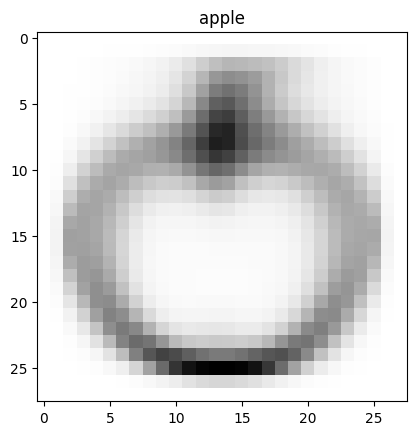

In [12]:
dataset.draw_mean_image(1)

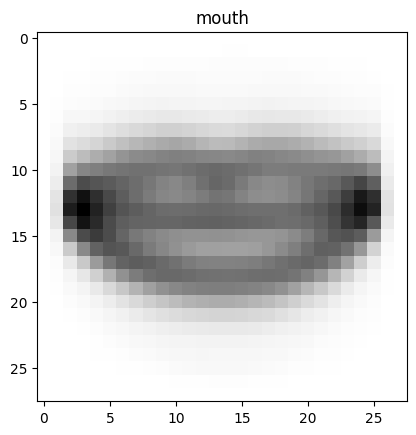

In [13]:
dataset.draw_mean_image(7)

## Divergent Examples

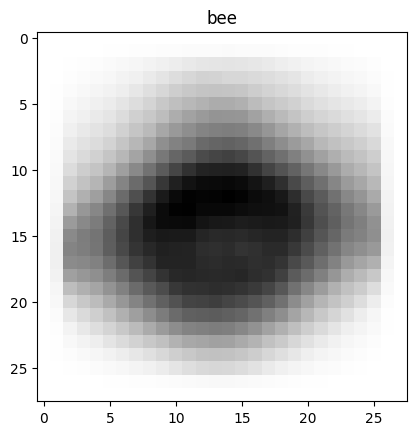

In [16]:
dataset.draw_mean_image(2)

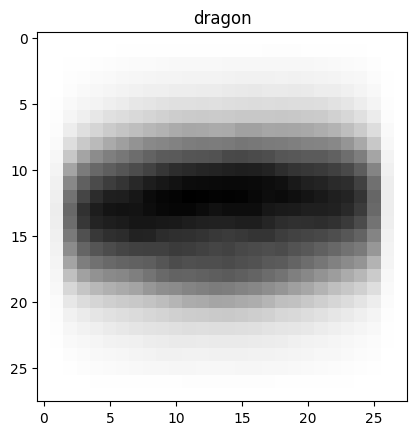

In [17]:
dataset.draw_mean_image(4)

## Training

In [ ]:
train_val_split = 0.2
learning_rate = 0.001
epochs = 30
batch_size = 128
experiment_name = 'test1'


writer = SummaryWriter()

dataset = QuickDrawDataset(root = './data')
train_ds, val_ds = dataset.split(train_val_split)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

criterion = torch.nn.CrossEntropyLoss() 
model = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2304, 512),
    nn.ReLU(),
    nn.Linear(512, len(dataset.classes)),
)
#model = SimpleCNN(len(dataset.classes))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = 0.0
    valid_loss = 0.0

    for i, batch in enumerate(train_dataloader, 0):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        #y = y.unsqueeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = criterion(logits.to(device), y.to(device))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size
        writer.add_scalar("Loss/train_iteration", loss.item(), epoch * len(train_dataloader) + i)

    model.eval()

    for i, batch in enumerate(validation_dataloader, 0):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        logits = model(x)

        loss = criterion(logits.to(device), y.to(device))

        valid_loss += loss.item() * batch_size

    model.train()


    writer.add_scalar("Loss/train", train_loss/len(train_dataloader.sampler), epoch)
    writer.add_scalar("Loss/test", valid_loss/len(validation_dataloader.sampler), epoch)
    writer.flush()


torch.save(model.state_dict(), './model_'+experiment_name+'.pth')
writer.close()


## Higher Resolution if needed 

In [18]:
def download_quickdraw_dataset_binary(root="./data/binary", class_names: List[str]=None):
    root = Path(root)
    root.mkdir(exist_ok=True, parents=True)
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'

    print("Downloading Quickdraw Dataset...")
    for class_name in tqdm(class_names, leave=True):
        fpath = root / f"{class_name}.bin"
        if not fpath.exists():
            urllib.request.urlretrieve(f"{url}{urllib.parse.quote(class_name, safe='')}.bin", fpath)

In [19]:
download_quickdraw_dataset_binary(class_names = ['train'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2353.71it/s]


In [20]:
import struct
from struct import unpack
import numpy as np
import cairocffi as cairo


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    country_code, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'country_code': country_code,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

def vector_to_raster(vector_images, side=128, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [21]:
image = None
for y in unpack_drawings('./data/binary/train.bin'):
    print(y.keys())
    image = y['image']
    break

dict_keys(['key_id', 'country_code', 'recognized', 'timestamp', 'image'])


In [22]:
myimg = vector_to_raster([image])

In [23]:
myimg = np.array(myimg).reshape(128,128,1)

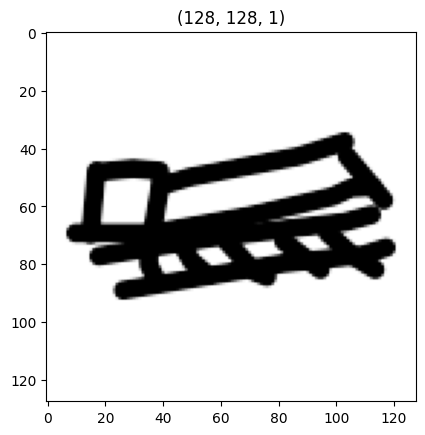

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(myimg, cmap='Greys')
plt.title(myimg.shape)
plt.show()